# Example 4.4: Spectrum of moments and accelerations

In this example, we will look at the stochastic response of a simply supported beam. The calculation will be performed in modal coordinates. The example will look at spectra of displacements, bending moments, and accelerations. 

The beam has two loads acting in the third point of the beam.

<center>
<img src="./figures/Beam_simplysupport.svg" width="300">
</center>

## Modal properties

The mode shapes are given as:

$$
\phi(x)=\sin \left(\dfrac{n \pi x}{L} \right), \quad n=1,2,3,\dots
$$

The generalized stiffness and mass can by calculated:

$$
k^* = \int_0^L EI(x) \left( \phi''(x) \right)^4 \, \text{d}x = EI \int_0^L \left( \dfrac{n \pi}{L} \right)^4 \sin^2\left( \dfrac{n \pi x}{L} \right) \, \text{d}x
= EI \left( \dfrac{n \pi}{L} \right)^4 \cdot \dfrac{L}{2} 
$$

$$
m^*=\int_0^L m(x) \phi (x) \: \text{d}x
= m \int_0^L  \sin^2(\dfrac{n \pi x}{L}) \: \text{d}x
=
\dfrac{mL}{2}
$$

The natural frequencies are:

$$
\omega_n=
\sqrt{\dfrac{k^*}{m^*}}=
n^2 \pi^2 \sqrt{ \dfrac{EI}{mL^4}}
$$

We mass normalize the mode shapes:

$$
\phi(x)=
\dfrac{1}{\sqrt{mL/2}}
\sin \left(\dfrac{n \pi x}{L} \right)
$$

After this normalization, the new modal mass is $m^*$ is 1 and $k^*$ will be $\omega_n^2$.
 

Natural frequencies in rad/s:
[ 3.12104295 12.4841718  28.08938656 49.93668722 78.02607378]


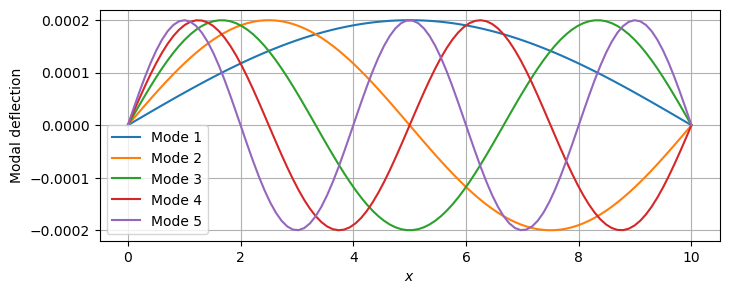

In [41]:
import numpy as np
from scipy import linalg as spla
from matplotlib import pyplot as plt

m=1000
L=10
EI=1e6

nm=5

omega_n=np.arange(1,nm+1)**2 *np.pi**2*np.sqrt(EI/(m*L**4))

print('Natural frequencies in rad/s:')
print(omega_n)

xi=0.03*np.ones_like(omega_n)

x=np.linspace(0,L,100)

plt.figure(figsize=(8,3))

# Plot 5 modes
for n in np.arange(1,nm+1):

    plt.plot(x, 1/(m*L/2)*np.sin(n*np.pi*x/L),label='Mode ' + str(n))

plt.xlabel('$x$')
plt.ylabel('Modal deflection')
plt.legend()
plt.grid()



## Load spectrum

We have a $2\times 2$ cross-spectral density matrix:

$$
\mathbf{S}_{\mathbf{x}}(\omega)
=
\left[ \begin{array}{cc} 
S_{x_1}(\omega) & S_{x_1 x_2}(\omega) \\
S_{x_2 x_1}(\omega) & S_{x_2}(\omega)
\end{array} \right]
$$

The auto spectral densities are:
$$
S_{x_1}(\omega)=S_{x_2}(\omega)=10^{10} \exp(-0.1 \sqrt{\omega})
$$

The cross-spectrum is defined as:
$$
S_{x_1 x_2}(\omega)
=
\sqrt{ S_{x_1}(\omega) S_{x_2}(\omega) }
a
$$

where $-1<a<1$. The parameter $a$ acts as a correlation coefficient between the two forces. We intitially set $a=0$, but you can try to change it to see the effect on the response.



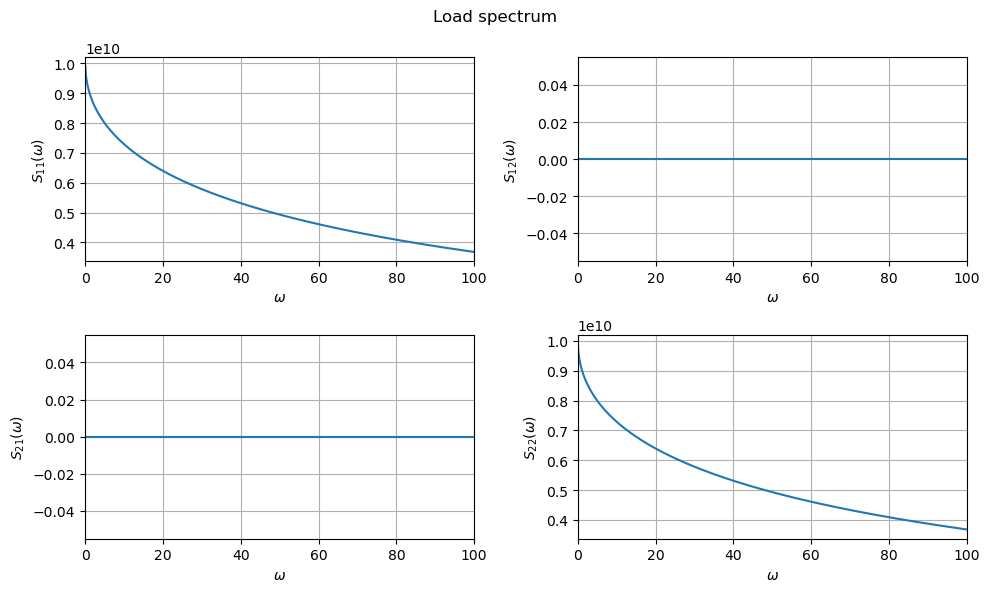

In [42]:
omega_axis=np.linspace(0.01,100,1000)

S0=1e10*np.exp(-0.1*omega_axis**0.5)

a=0

Sx=np.zeros((2,2,len(omega_axis)))
Sx[0,0,:]=S0
Sx[1,1,:]=S0
Sx[0,1,:]=S0*a
Sx[1,0,:]=S0*a


# Plot
fig, axs = plt.subplots(2, 2,figsize=(10, 6))

for i in np.arange(2):
    for j in np.arange(2):
        axs[i,j].plot(omega_axis,Sx[i,j,:])
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,100)
        axs[i,j].grid(True)

fig.suptitle('Load spectrum')
plt.tight_layout()


## Modal load spectrum

The modal load is given by $
\mathbf{\tilde{x}}(t)
=
\mathbf{\Phi}_L^\text{T}
\mathbf{x}(t)
$.
Therefore, the spectrum of the modal load is: 
$$
\mathbf{S}_\mathbf{\tilde{x}}(\omega)
=\mathbf{\Phi}_L^\text{T}
\mathbf{S}_\mathbf{x}(\omega)
\mathbf{\Phi}_L
$$

We have to construct $\mathbf{\Phi}_L$ as the matrix that contains the mode shape values for the load locations (i.e., the third points).


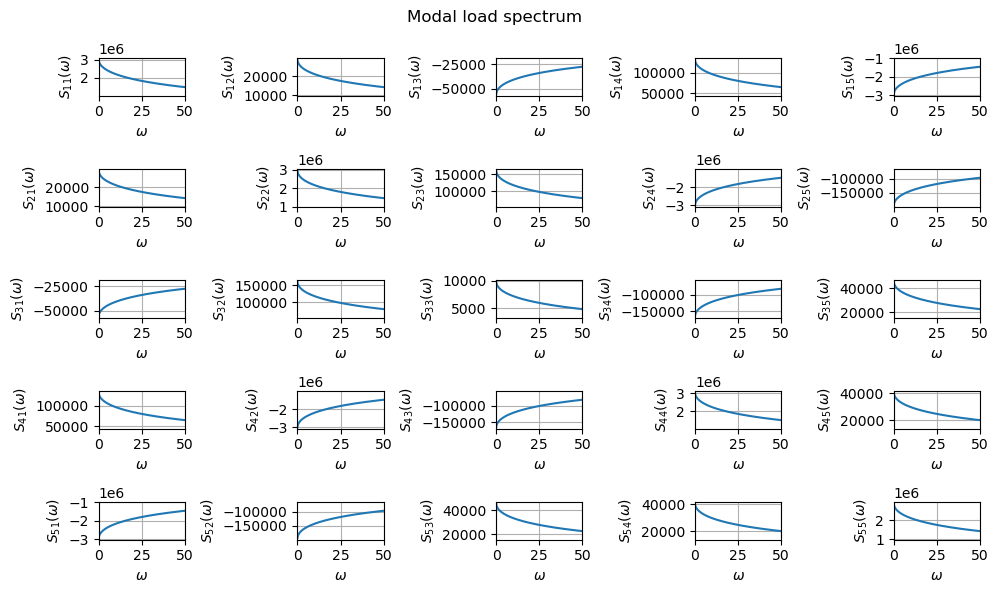

In [43]:

x_load=np.array([0.33*L,0.66*L])

Phi_load=np.zeros((2,nm))
for n in np.arange(1,nm+1):
    Phi_load[:,n-1]=1/np.sqrt(m*L/2)*np.sin(n*np.pi*x_load/L)

Sx_modal=np.zeros((nm,nm,len(omega_axis)))
for k in np.arange(len(omega_axis)):
    Sx_modal[:,:,k]=Phi_load.T @ Sx[:,:,k] @ Phi_load

# Plot
fig, axs = plt.subplots(5, 5,figsize=(10, 6))

for i in np.arange(5):
    for j in np.arange(5):
        axs[i,j].plot(omega_axis,Sx_modal[i,j,:])
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,50)
        axs[i,j].grid(True)

fig.suptitle('Modal load spectrum')
plt.tight_layout()


## Frequency response function

The modal frequency response function is:

$$
\mathbf{\tilde{H}} (\omega)
=
\left[
-\omega^2 \mathbf{I}
+i \omega 2 \cdot \textbf{diag} (\xi) \cdot \textbf{diag} (\omega_n)
+ \textbf{diag} (\omega_n^2)
\right]
^{-1}
$$

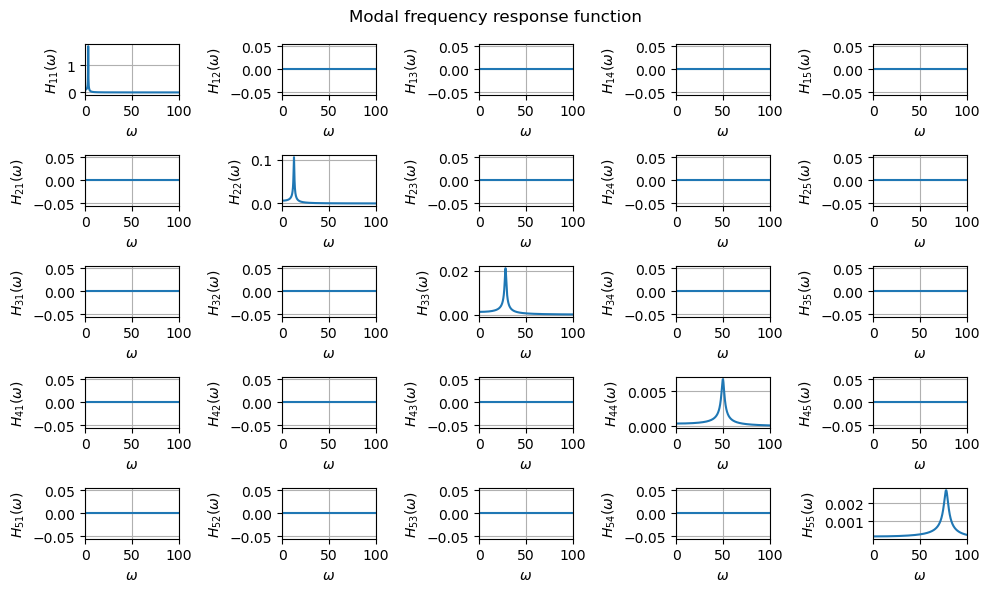

In [44]:
H_modal=np.zeros((nm,nm,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    tmp=-omega_axis[k]**2*np.eye(nm)+1j*omega_axis[k]*2*np.diag(omega_n)*np.diag(xi)+np.diag(omega_n)**2
    H_modal[:,:,k]=np.linalg.inv(tmp)

# Plot
fig, axs = plt.subplots(5, 5,figsize=(10, 6))

for i in np.arange(5):
    for j in np.arange(5):
        axs[i,j].plot(omega_axis,np.abs(H_modal[i,j,:]))
        #axs[i,j].plot(omega_axis,np.imag(H_modal[i,j,:]))
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$H_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,100)
        axs[i,j].grid(True)

fig.suptitle('Modal frequency response function')
plt.tight_layout()


## Modal response spectrum

The cross-spectral density matrix of the modal response is:

$$
\mathbf{S}_\mathbf{z}(\omega)
=
\mathbf{\tilde{H} (\omega) }
\mathbf{S}_\mathbf{\tilde{x}}(\omega)
\overline{\mathbf{\tilde{H}}} (\omega)^\text{T}
$$

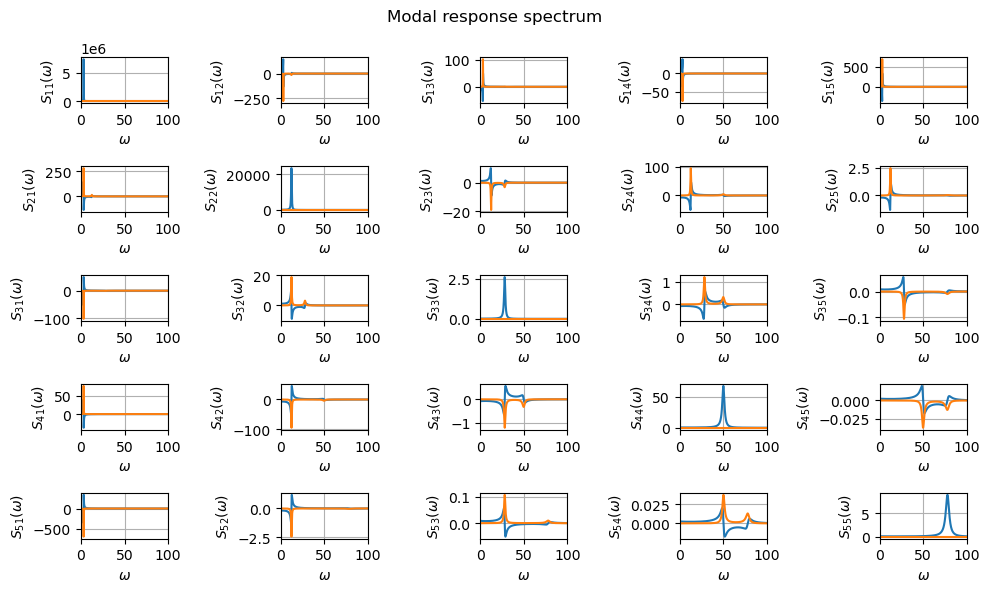

In [45]:
Sz=np.zeros((nm,nm,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Sz[:,:,k]=H_modal[:,:,k] @ Sx_modal[:,:,k] @ np.conj(H_modal[:,:,k]).T

# Plot
fig, axs = plt.subplots(5, 5,figsize=(10, 6))

for i in np.arange(5):
    for j in np.arange(5):
        axs[i,j].plot(omega_axis,np.real(Sz[i,j,:]))
        axs[i,j].plot(omega_axis,np.imag(Sz[i,j,:]))
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,100)
        axs[i,j].grid(True)

fig.suptitle('Modal response spectrum')
plt.tight_layout()

## Displacement response spectrum


The displacement response is given by $
\mathbf{y}(t)
=
\mathbf{\Phi}_D
\mathbf{z}(t)
$. Therefore, the spectrum of the displacement response is: 
$$
\mathbf{S}_\mathbf{y}(\omega)
=\mathbf{\Phi}_D
\mathbf{S}_\mathbf{z}(\omega)
\mathbf{\Phi}_D^\text{T}
$$


We have to construct $\mathbf{\Phi}_D$ as the matrix that contains the mode shape values for the displacement response locations. We will check the response in the quarter and mid points of the beam: $x=\dfrac{L}{4}$ and $x=\dfrac{L}{2}$.


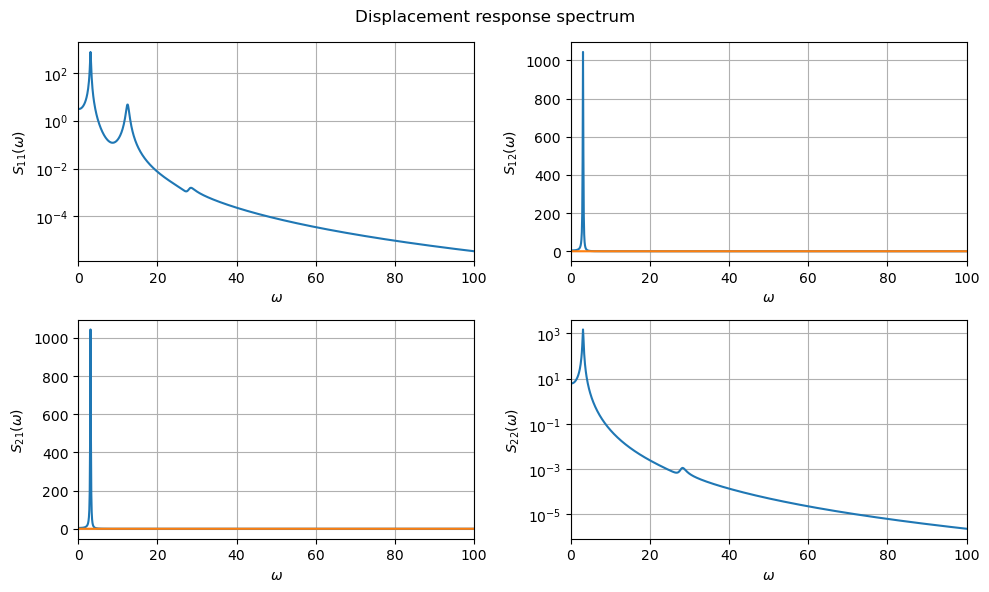

In [46]:
x_disp=np.array([0.25*L,0.5*L])

Phi_disp=np.zeros((2,nm))
for n in np.arange(1,nm):
    Phi_disp[:,n-1]=1/np.sqrt(m*L/2)*np.sin(n*np.pi*x_disp/L)

Sy=np.zeros((2,2,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Sy[:,:,k]=Phi_disp @ Sz[:,:,k] @ Phi_disp.T

# Plot
fig, axs = plt.subplots(2, 2,figsize=(10, 6))

for i in np.arange(2):
    for j in np.arange(2):
        axs[i,j].plot(omega_axis,np.real(Sy[i,j,:]))

        if i!=j: 
            axs[i,j].plot(omega_axis,np.imag(Sy[i,j,:])) # Plot imaginary part only for cross-spectrum
        
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,100)
        axs[i,j].grid(True)

        if i==j:
            axs[i,j].set_yscale('log')

fig.suptitle('Displacement response spectrum')
plt.tight_layout()

## Moment response spectrum

The displacement response is given by
$
y(x,t)=
\sum_{n=1}^{n_m}
\phi_n(x) z_n(t)
$.

From beam theory, we know that the moment is $M(x,t)=EI \cdot y''(x,t)$. The result is that we differentiate twice the mode shape:

$$
M(x,t)=EI \cdot y''(x,t)
=
EI
\sum_{n=1}^{n_m}
\phi_n ''(x) z_n(t)
=
\sum_{n=1}^{n_m}
EI
\dfrac{1}{\sqrt{mL/2}}
\dfrac{n^2 \pi^2}{L^2}
\sin \left(\dfrac{n \pi x}{L} \right)
 z_n(t)
$$

We interpret $EI
\dfrac{1}{\sqrt{mL/2}}
\dfrac{n^2 \pi^2}{L^2}
\sin \left(\dfrac{n \pi x}{L} \right)$ as the bending mode mode shape of the beam. This will be similar to the displacement mode shapes, but we also have the factor $n^2$. This will give a higher weight to higher modes. Therefore, modes that were not important for the displacements can be important for the moment.

The spectrum of the bending moments response is: 
$$
\mathbf{S}_\mathbf{M}(\omega)
=\mathbf{\Phi}_B
\mathbf{S}_\mathbf{z}(\omega)
\mathbf{\Phi}_B^\text{T}
$$

We have to construct $\mathbf{\Phi}_B$ as the matrix that contains the bending mode shape values for the  locations  $x=\dfrac{L}{4}$ and $x=\dfrac{L}{2}$.




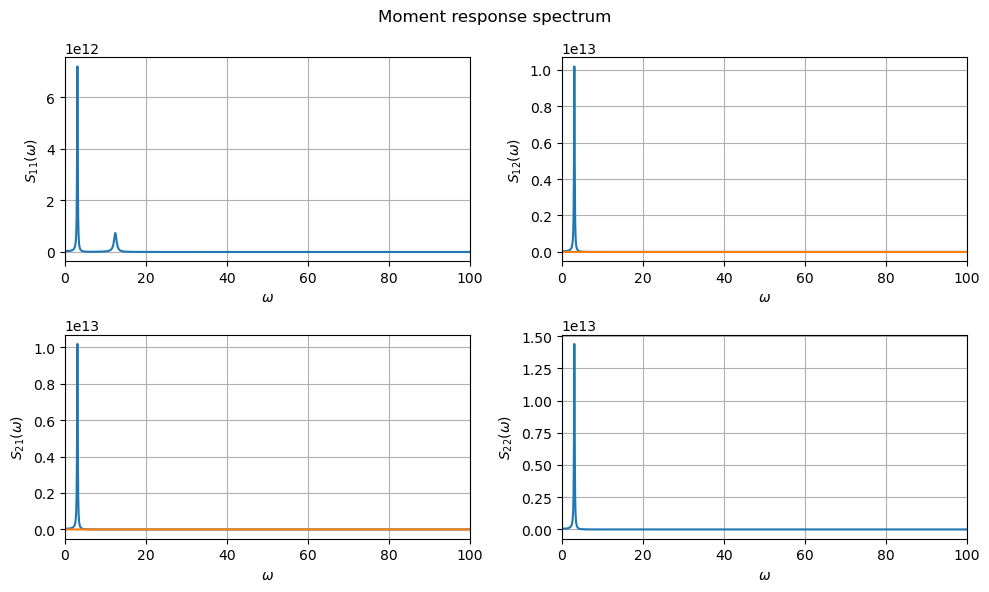

In [47]:
x_moment=np.array([0.25*L,0.5*L])

Phi_moment=np.zeros((2,nm))
for n in np.arange(1,nm):
    Phi_moment[:,n-1]=EI*1/np.sqrt(m*L/2)*(n*np.pi/L)**2*np.sin(n*np.pi*x_moment/L)


Sm=np.zeros((2,2,len(omega_axis)),dtype=complex)
for k in np.arange(len(omega_axis)):
    Sm[:,:,k]=Phi_moment @ Sz[:,:,k] @ Phi_moment.T

# Plot
fig, axs = plt.subplots(2, 2,figsize=(10, 6))

for i in np.arange(2):
    for j in np.arange(2):
        axs[i,j].plot(omega_axis,np.real(Sm[i,j,:]))

        if i!=j: 
            axs[i,j].plot(omega_axis,np.imag(Sm[i,j,:])) # Plot imaginary part only for cross-spectrum
        
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,100)
        axs[i,j].grid(True)

        #if i==j:
            #axs[i,j].set_yscale('log')

fig.suptitle('Moment response spectrum')
plt.tight_layout()

## Acceleration response spectrum

The acceleration response spectrum is derived from the displacement spectrum using the following relationship:

$$
\mathbf{S}_\mathbf{\ddot{y}}(\omega) = \omega^4 \mathbf{S}_\mathbf{y}(\omega)
$$

The scaling factor $\omega^4$ indicates that higher-frequency modes (with larger $\omega$) will have a greater influence.   The contribution of higher-order modes can be important for the acceleration response, even if their contribution to the displacement spectrum is relatively small.

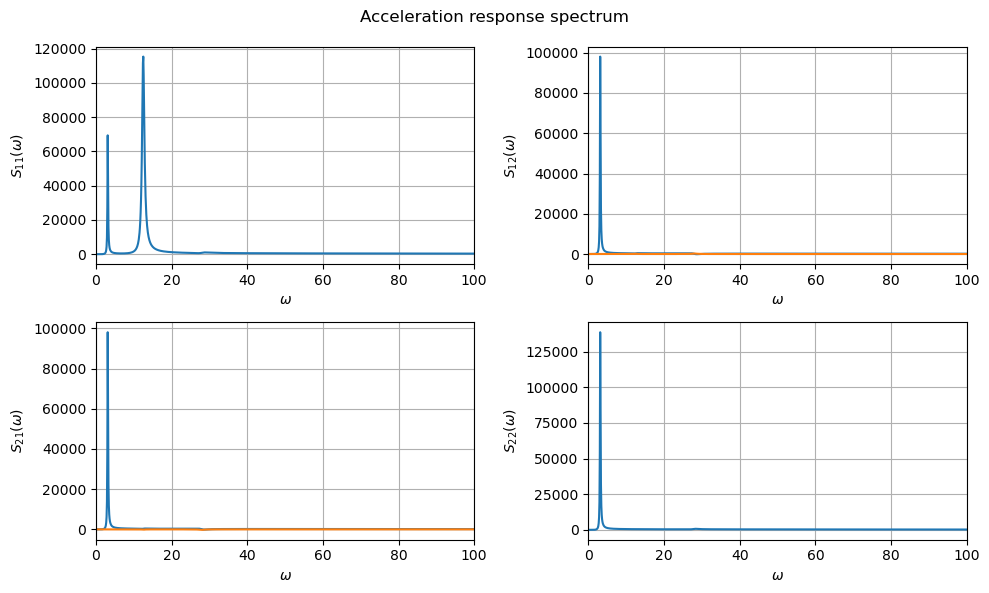

In [48]:

Syddot=np.zeros_like(Sy)
for k in np.arange(len(omega_axis)):
    Syddot[:,:,k]=Sy[:,:,k]*omega_axis[k]**4

# Plot
fig, axs = plt.subplots(2, 2,figsize=(10, 6))

for i in np.arange(2):
    for j in np.arange(2):
        axs[i,j].plot(omega_axis,np.real(Syddot[i,j,:]))

        if i!=j: 
            axs[i,j].plot(omega_axis,np.imag(Syddot[i,j,:])) # Plot imaginary part only for cross-spectrum
        
        axs[i,j].set_xlabel(r'$\omega$')
        axs[i,j].set_ylabel(r'$S_{' + str(i+1) + str(j+1) + '} (\omega)$')
        axs[i,j].set_xlim(0,100)
        axs[i,j].grid(True)

        #if i==j:
            #axs[i,j].set_yscale('log')

fig.suptitle('Acceleration response spectrum')
plt.tight_layout()